In [218]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings("ignore")
import sklearn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, matthews_corrcoef, median_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
import matplotlib.pyplot as plt
from sklearn import model_selection
import time
from sklearn.neural_network import MLPRegressor
import os
from sklearn.preprocessing import LabelEncoder


pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000

In [237]:
dr = 'exp/prepared/'
file_names = os.listdir(dr)

def lowerstr(f):
    for col in f:
        if '№ партии' in col:
            f['№ партии'] = f['№ партии'].str.lower()
        if '№ плавки' in col:
            f['№ плавки'] = f['№ плавки'].str.lower()
    return f


df_modes = pd.read_excel('merge_table_mean_chem.xlsx')
table_stretching = pd.read_excel(dr+file_names[17])
table_stretching = lowerstr(table_stretching)

In [238]:
table_stretching.shape

(31091, 36)

In [239]:
ls_all = [
    'Поставщик',
    'НД (гост, ту)',
    'ГОСТ, ТУ',
    'Дата форм. цехом',
    'марка стали',
    '№ плавки',
    'кол-во, шт.',
    '№ партии',
    '1 зона по ВТР закалка', 
    '1 зона уставка закалка',
    '1 зона фактическая температура закалка', 
    '2 зона по ВТР закалка',
    '3 зона по ВТР закалка', 
    '3 зона уставка закалка',
    '3 зона фактическая температура закалка',
    'Температура трубы на выгрузке из печи закалки',
    'Скорость прохождения трубы через спрейер, м/с',
    't˚ C трубы после спреера', 
    'Расход воды на закалочный спрейер, м3',
    'время выдержки в закалочной ванне, сек.',
    't˚ C воды в закалочной ванне', 
    't˚ C трубы после ванны',
    '1 зона ВТР и уставка отпуск', 
    '1 зона фактическая температура отпуск',
    '2 зона ВТР и уставка отпуск', 
    '3 зона ВТР и уставка отпуск',
    '3 зона фактическая температура отпуск', 
    '4 зона ВТР и уставка отпуск',
    '5 зона ВТР и уставка отпуск', 
    '5 зона фактическая температура отпуск',
    'Температура трубы на выгрузке из печи отпуска',
    'шаг балок закалочная печь, сек', 
    'шаг балок отпускная печь, сек',
    'диаметр', 
    'толщина стенки', 
    'C', 
    'Mn', 
    'Si', 
    'P', 
    'S',
    'Cr', 
    'Ni', 
    'Cu', 
    'Al', 
    'V', 
    'Ti', 
    'Nb', 
    'Mo', 
    'N', 
    'B',
    'Параметр',
    'Тип предела текучести 0.2',
    'Тип предела текучести 0.5',
    'Тип предела текучести 0.6',
    'C-coef'
]

In [240]:
table_stretching.shape

(31091, 36)

In [241]:
df_merge = pd.merge(df_modes, table_stretching, how ='left', on = ['№ плавки','№ партии'])

chem = {#'Mn': 0, 'Si': 0, 
#         'P': 0, 
#         'Cr': 0, 'Ni': 0, 'Cu': 0, 'Al': 0, 'V': 0, 'Mo': 0, 
        'Ti': 0, 'Nb': 0, 'N': 0.004, 'B': 0.001, 'S': 0}

df_merge = df_merge.fillna(value = chem)

In [242]:
df_merge.shape

(30298, 82)

In [243]:
df_merge['Параметр'] = ((df_merge['3 зона фактическая температура отпуск']+df_merge['4 зона ВТР и уставка отпуск']+df_merge['5 зона фактическая температура отпуск'])/3
                        + 273)*(20+np.log(94*df_merge['шаг балок отпускная печь, сек']))*1e-3

In [244]:
df_merge['Тип предела текучести (1186)'] = df_merge['Тип предела текучести (1186)'].apply(lambda x: str(x))

In [245]:
# df_merge = df_merge[df_merge['Врем. сопротивление'] != '']
# df_merge = df_merge[df_merge['Предел текучести'] != '']
df_merge = df_merge[df_merge['t˚ C трубы после спреера'] != ' ']

In [246]:
df_merge.shape

(30289, 83)

In [247]:
df_merge.head()

,№ плавки,№ партии,"НД (гост, ту)",марка стали,"кол-во, шт.",1 зона по ВТР закалка,1 зона уставка закалка,1 зона фактическая температура закалка,2 зона по ВТР закалка,3 зона по ВТР закалка,3 зона уставка закалка,3 зона фактическая температура закалка,Температура трубы на выгрузке из печи закалки,"Скорость прохождения трубы через спрейер, м/с",t˚ C трубы после спреера,"Расход воды на закалочный спрейер, м3","время выдержки в закалочной ванне, сек.",t˚ C воды в закалочной ванне,t˚ C трубы после ванны,1 зона ВТР и уставка отпуск,1 зона фактическая температура отпуск,2 зона ВТР и уставка отпуск,3 зона ВТР и уставка отпуск,3 зона фактическая температура отпуск,4 зона ВТР и уставка отпуск,5 зона ВТР и уставка отпуск,5 зона фактическая температура отпуск,Температура трубы на выгрузке из печи отпуска,"шаг балок закалочная печь, сек","шаг балок отпускная печь, сек",диаметр,толщина стенки,Поставщик,C,Mn,Si,P,S,Cr,Ni,Cu,Al,V,Ti,Nb,Mo,N,B,Тип предела текучести (1186),Дата форм. цехом,№ заявки,"ГОСТ, ТУ",Гр. прочн.,Марка стали,Диаметр,Стенка,Предел текучести (1027),Относительное удлинение (1099),Врем. сопротивление (1042),Отношение (1118),Относительное сужение (1016),Предел текучести (1141),Врем. сопротивление (1140),Диаметр образца (1225),Толщина (1226),min Предел текучести (1027),max Предел текучести (1027),min Относительное удлинение (1099),min Врем. сопротивление (1042),max Врем. сопротивление (1042),max Отношение (1118),"Предел текучести, Ksi (1145)","Врем. сопротивление, Ksi (1146)","Предел текучести, кгс/мм2","Врем. сопротивление, кгс/мм2","Предел текучести, Н/мм2 или МПа","Врем. сопротивление, Н/мм2 или МПа","Предел текучести , кгс/мм2","Врем. сопротивление , кгс/мм2","Тип предела текучести, Н/мм2 или МПа",Врем. сопротивление,Предел текучести,Параметр
0,10034,305311,ТУ 3,38Г2С,50,860.0,860.0,861.0,860.0,870.0,853.0,853.0,861.0,1.0,NaN,116.0,NaN,27.0,NaN,605.0,604.0,605.0,597.0,599.0,597.0,584.0,584.0,582.0,30.0,30.0,73.00,5.5,"АО ""ОЭМК""",0.38,1.72,0.49,0.011,0.009,0.06,0.03,0.04,NaN,NaN,0.0000,0.0,NaN,0.004,0.001,0.2,27.05.2013,431972.0,ГОСТ 633-80 Исполнение А,Д,38Г2С,73.00,5.5,40.0,26.5,76.5,0.52,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.5,40.0,24.209245
1,10035,305309,ТУ 3,38Г2С,50,860.0,860.0,865.0,860.0,870.0,853.0,852.0,861.0,1.0,NaN,117.0,NaN,27.0,NaN,605.0,607.0,605.0,597.0,596.0,597.0,584.0,585.0,582.0,30.0,30.0,73.00,5.5,"АО ""ОЭМК""",0.39,1.64,0.46,0.009,0.006,0.05,0.03,0.07,NaN,NaN,0.0000,0.0,NaN,0.004,0.001,0.2,27.05.2013,431968.0,ГОСТ 633-80 Исполнение А,Д,38Г2С,73.00,5.5,39.0,24.0,78.0,0.50,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,39.0,24.190615
2,10043,202198,ту78,30Г2,20,890.0,890.0,891.0,890.0,900.0,900.0,901.0,898.0,1.0,NaN,1813.0,30.0,23.0,25.0,520.0,522.0,525.0,517.0,515.0,522.0,517.0,517.0,524.0,39.0,39.0,107.95,14.0,"АО ""ОЭМК""",0.28,1.32,0.25,0.008,0.007,0.05,0.03,0.04,0.027,0.002,0.0012,0.0,0.007,0.004,0.001,0.2,15.02.2012,407998.0,ГОСТ 633-80,Л,30Г2,107.95,14.0,71.5,16.5,86.5,0.83,65.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.5,71.5,22.311623
3,10043,402040,ТУ 78,30Г2,15,900.0,900.0,900.0,900.0,910.0,908.0,908.0,895.0,1.0,NaN,37.0,NaN,23.0,42.5,570.0,569.0,570.0,564.0,563.0,564.0,555.0,555.0,558.0,36.0,36.0,107.95,14.0,"АО ""ОЭМК""",0.28,1.32,0.25,0.008,0.007,0.05,0.03,0.04,0.027,0.002,0.0012,0.0,0.007,0.004,0.001,0.2,03.02.2014,442750.0,ГОСТ 633-80 Исполнение А,К,30Г2,107.95,14.0,65.0,20.0,81.0,0.80,69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.0,65.0,23.448387
4,10050,305312,ТУ 3,38Г2С,28,860.0,860.0,861.0,860.0,870.0,853.0,853.0,860.0,1.0,NaN,116.0,NaN,27.0,NaN,605.0,606.0,605.0,597.0,596.0,597.0,584.0,583.0,582.0,30.0,30.0,73.00,5.5,"АО ""ОЭМК""",0.37,1.67,0.51,0.013,0.007,0.05,0.03,0.04,NaN,NaN,0.0000,0.0,NaN,0.004,0.001,0.2,27.05.2013,431974.0,ГОСТ 633-80 Исполнение А,Д,38Г2С,73.00,5.5,41.0,28.0,79.5,0.52,67.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [248]:
ls_type = [
    'Тип предела текучести 0.2',
    'Тип предела текучести 0.5',
    'Тип предела текучести 0.6',
    'del'
]
df_merge[ls_type] = pd.get_dummies(df_merge['Тип предела текучести (1186)'])

In [249]:
ls_steel = pd.get_dummies(df_merge['марка стали']).columns
ls_steel = list(ls_steel)

In [250]:
len(ls_steel)

66

In [251]:
df_merge[ls_steel] = pd.get_dummies(df_merge['марка стали'])

In [407]:
df_merge.shape

(28547, 154)

In [122]:
df_merge = df_merge.reset_index(drop=True)

In [123]:
df_merge.head()

,№ плавки,№ партии,"НД (гост, ту)",марка стали,"кол-во, шт.",1 зона по ВТР закалка,1 зона уставка закалка,1 зона фактическая температура закалка,2 зона по ВТР закалка,3 зона по ВТР закалка,3 зона уставка закалка,3 зона фактическая температура закалка,Температура трубы на выгрузке из печи закалки,"Скорость прохождения трубы через спрейер, м/с",t˚ C трубы после спреера,"Расход воды на закалочный спрейер, м3","время выдержки в закалочной ванне, сек.",t˚ C воды в закалочной ванне,t˚ C трубы после ванны,1 зона ВТР и уставка отпуск,1 зона фактическая температура отпуск,2 зона ВТР и уставка отпуск,3 зона ВТР и уставка отпуск,3 зона фактическая температура отпуск,4 зона ВТР и уставка отпуск,5 зона ВТР и уставка отпуск,5 зона фактическая температура отпуск,Температура трубы на выгрузке из печи отпуска,"шаг балок закалочная печь, сек","шаг балок отпускная печь, сек",диаметр,толщина стенки,Поставщик,C,Mn,Si,P,S,Cr,Ni,Cu,Al,V,Ti,Nb,Mo,N,B,Тип предела текучести (1186),Дата форм. цехом,...,18ХМФБ-в2,20,20А,20А-1,20А-У,20А-пр,20Г2,20Г2-1,20ФА,20ХМФА,20ХФА,26Г1ФМ,30Г2,30Г2,30Г2-2,30Г2-3,30Г2-5,30Г2-8,30Г2Ф,30Г3,30ХГМА,30ХГМА-1,30ХГМА-4,30ХГСА,30ХМА,32Г1,32Г2,32Г2СФБ,32Х1МФ,32Х1МФ-1,32ХА,32ХГ,32ХНМ,35ХМФA,36ХГ2СФБ,36ХГФ,37Г2С,37Г2Ф,37Г2Ф-М,38Г2-4,38Г2С,38Г2С-1,38Г2С-3,38Г2С-4,38Г2С-9,38Г2С-В,38Г2СФ,Д,ДБ,C-coef
0,10034,305311,ТУ 3,38Г2С,50,860.0,860.0,861.0,860.0,870.0,853.0,853.0,861.0,1.0,NaN,116.0,NaN,27.0,NaN,605.0,604.0,605.0,597.0,599.0,597.0,584.0,584.0,582.0,30.0,30.0,73.00,5.5,"АО ""ОЭМК""",0.38,1.72,0.49,0.011,0.009,0.06,0.03,0.04,NaN,NaN,0.0000,0.0,0.000,0.0,0.0,0.2,27.05.2013,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN
1,10035,305309,ТУ 3,38Г2С,50,860.0,860.0,865.0,860.0,870.0,853.0,852.0,861.0,1.0,NaN,117.0,NaN,27.0,NaN,605.0,607.0,605.0,597.0,596.0,597.0,584.0,585.0,582.0,30.0,30.0,73.00,5.5,"АО ""ОЭМК""",0.39,1.64,0.46,0.009,0.006,0.05,0.03,0.07,NaN,NaN,0.0000,0.0,0.000,0.0,0.0,0.2,27.05.2013,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN
2,10043,202198,ту78,30Г2,20,890.0,890.0,891.0,890.0,900.0,900.0,901.0,898.0,1.0,NaN,1813.0,30.0,23.0,25.0,520.0,522.0,525.0,517.0,515.0,522.0,517.0,517.0,524.0,39.0,39.0,107.95,14.0,"АО ""ОЭМК""",0.28,1.32,0.25,0.008,0.007,0.05,0.03,0.04,0.027,0.002,0.0012,0.0,0.007,0.0,0.0,0.2,15.02.2012,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.283133
3,10043,402040,ТУ 78,30Г2,15,900.0,900.0,900.0,900.0,910.0,908.0,908.0,895.0,1.0,NaN,37.0,NaN,23.0,42.5,570.0,569.0,570.0,564.0,563.0,564.0,555.0,555.0,558.0,36.0,36.0,107.95,14.0,"АО ""ОЭМК""",0.28,1.32,0.25,0.008,0.007,0.05,0.03,0.04,0.027,0.002,0.0012,0.0,0.007,0.0,0.0,0.2,03.02.2014,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.283133
4,10050,305312,ТУ 3,38Г2С,28,860.0,860.0,861.0,860.0,870.0,853.0,853.0,860.0,1.0,NaN,116.0,NaN,27.0,NaN,605.0,606.0,605.0,597.0,596.0,597.0,584.0,583.0,582.0,30.0,30.0,73.00,5.5,"АО ""ОЭМК""",0.37,1.67,0.51,0.013,0.007,0.05,0.03,0.04,NaN,NaN,0.0000,0.0,0.000,0.0,0.0,0.2,27.05.2013,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN


In [409]:
df_merge = df_merge[df_merge['Cr'] < 10]

In [410]:
df_merge['C-coef'] = ((df_merge['C'] + df_merge['Mn'])/6.0 + (df_merge['Cr'] + df_merge['Mo'] + df_merge['V'])/5.0 +
                        (df_merge['Ni'] + df_merge['Cu'])/15.0)

In [411]:
df_merge.shape

(28547, 154)

In [412]:
df_merge.to_excel('prepared_hard.xlsx')

In [5]:
df_merge = pd.read_excel('prepared_hard.xlsx')

In [180]:
ls_need_col = [
#     'Поставщик',
#     'НД (гост, ту)',
#     'ГОСТ, ТУ',
#     'Дата форм. цехом',
#      'марка стали',
#     '№ плавки',
#     'кол-во, шт.',
#     '№ партии',
#     '1 зона по ВТР закалка', 
#     '1 зона уставка закалка',
    '1 зона фактическая температура закалка', 
    '2 зона по ВТР закалка',
#     '3 зона по ВТР закалка', 
    '3 зона уставка закалка',
#     '3 зона фактическая температура закалка',
    'Температура трубы на выгрузке из печи закалки',
    'Скорость прохождения трубы через спрейер, м/с',
    't˚ C трубы после спреера', 
#     'Расход воды на закалочный спрейер, м3',
#     'время выдержки в закалочной ванне, сек.',
#     't˚ C воды в закалочной ванне', 
#     't˚ C трубы после ванны',
#     '1 зона ВТР и уставка отпуск', 
    '1 зона фактическая температура отпуск',
    '2 зона ВТР и уставка отпуск', 
#     '3 зона ВТР и уставка отпуск',
    '3 зона фактическая температура отпуск', 
    '4 зона ВТР и уставка отпуск',
#     '5 зона ВТР и уставка отпуск', 
    '5 зона фактическая температура отпуск',
    'Температура трубы на выгрузке из печи отпуска',
    'шаг балок закалочная печь, сек', 
    'шаг балок отпускная печь, сек',
    'диаметр', 
    'толщина стенки', 
    'C', 
    'Mn', 
    'Si', 
    'P', 
    'S',
    'Cr', 
    'Ni', 
    'Cu', 
    'Al', 
    'V', 
    'Ti', 
    'Nb', 
    'Mo', 
    'N', 
    'B',
    'Параметр',
    'Тип предела текучести 0.2',
    'Тип предела текучести 0.5',
    'Тип предела текучести 0.6',
#     'C-coef'
]

df_prepared_merge = pd.DataFrame()

for col in ls_need_col+['Предел текучести', 'Врем. сопротивление']: #ls_steel
    df_prepared_merge[col] = df_merge[col]

In [181]:
# df_prepared_merge['НД (гост, ту)'] = df_prepared_merge['НД (гост, ту)'].apply(lambda x: str(x))

In [182]:
label = LabelEncoder()  
# print(df_prepared_merge['марка стали'])
# df_prepared_merge['марка стали'] = label.fit_transform(df_prepared_merge['марка стали'])
# df_prepared_merge['НД (гост, ту)'] = label.fit_transform(df_prepared_merge['НД (гост, ту)'])
# print(df_prepared_merge['марка стали'])

In [183]:
# df_prepared_merge = df_prepared_merge[df_prepared_merge['t˚ C трубы после спреера'] != ' ']

In [184]:
df_prepared_merge = df_prepared_merge.dropna()
df_prepared_merge.shape

(19545, 37)

In [200]:
print(df_prepared_merge['Предел текучести'].describe())
print(df_prepared_merge['Врем. сопротивление'].describe())

count    19545.000000
mean        66.205779
std         24.099144
min         25.000000
25%         62.661561
50%         67.097327
75%         71.500000
max        880.000000
Name: Предел текучести, dtype: float64
count    19545.000000
mean        76.378611
std         25.625659
min         38.500000
25%         73.011681
50%         76.376744
75%         81.118425
max        947.500000
Name: Врем. сопротивление, dtype: float64


In [192]:
import seaborn as sns

In [193]:
corr_matrix = df_merge[ls_need_col+['Предел текучести']].corr()
sns_corr = sns.heatmap(corr_matrix).get_figure()
sns_corr.savefig('corr_прочность.png')

In [185]:
df_prepared_merge = df_prepared_merge.reset_index(drop=True)

In [186]:
df_prepared_merge.head()

,1 зона фактическая температура закалка,2 зона по ВТР закалка,3 зона уставка закалка,Температура трубы на выгрузке из печи закалки,"Скорость прохождения трубы через спрейер, м/с",t˚ C трубы после спреера,1 зона фактическая температура отпуск,2 зона ВТР и уставка отпуск,3 зона фактическая температура отпуск,4 зона ВТР и уставка отпуск,5 зона фактическая температура отпуск,Температура трубы на выгрузке из печи отпуска,"шаг балок закалочная печь, сек","шаг балок отпускная печь, сек",диаметр,толщина стенки,C,Mn,Si,P,S,Cr,Ni,Cu,Al,V,Ti,Nb,Mo,N,B,Параметр,Тип предела текучести 0.2,Тип предела текучести 0.5,Тип предела текучести 0.6,Предел текучести,Врем. сопротивление
0,849.0,850.0,848.0,852.0,0.54,50.0,561.0,560.0,556.0,555.0,547.0,561.0,28.0,27.0,88.9,6.5,0.270,1.29,0.29,0.008,0.004,0.025,0.049,0.013,0.029,0.0049,0.0025,0.000,0.005,0.0,0.0,20.264580,1,0,0,77.5,86.0
1,878.0,880.0,885.0,880.0,0.23,60.0,683.0,705.0,674.0,691.0,656.0,702.0,42.0,38.0,114.0,10.0,0.212,0.54,0.32,0.011,0.006,0.357,0.047,0.010,0.031,0.0480,0.0040,0.037,0.005,0.0,0.0,23.234319,1,0,0,47.0,65.0
2,880.0,880.0,880.0,878.0,0.30,45.0,721.0,720.0,704.0,706.0,693.0,721.0,42.0,38.0,114.0,8.0,0.200,0.42,0.18,0.013,0.016,0.030,0.060,0.050,0.029,0.0700,0.0000,0.036,0.005,0.0,0.0,23.905169,1,0,0,44.5,64.0
3,879.0,880.0,877.0,874.0,0.30,45.0,721.0,720.0,704.0,706.0,691.0,718.0,42.0,38.0,114.0,8.0,0.225,0.59,0.22,0.010,0.008,0.370,0.051,0.011,0.023,0.0400,0.0000,0.036,0.005,0.0,0.0,23.888807,1,0,0,45.5,62.5
4,851.0,860.0,848.0,850.0,0.27,45.0,554.0,555.0,549.0,550.0,544.0,553.0,33.0,33.0,168.3,8.0,0.283,1.36,0.26,0.010,0.008,0.058,0.046,0.007,0.033,0.0460,0.0036,0.000,0.005,0.0,0.0,20.141864,1,0,0,72.5,82.0


In [187]:
y = pd.DataFrame()
X = pd.DataFrame()

# y['Врем. сопротивление'] = df_prepared_merge['Врем. сопротивление']
y['Предел текучести'] = df_prepared_merge['Предел текучести']


for i in ls_need_col+ls_steel:
    X[i] = df_prepared_merge[i]

KeyError: '08ХГМФБ'

In [ ]:
X['C']

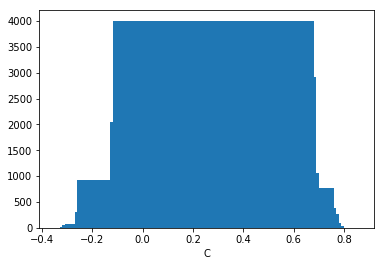

count    19545.000000
mean         0.261192
std          0.071822
min          0.050000
25%          0.190000
50%          0.280000
75%          0.290000
max          0.460000
Name: C, dtype: float64

In [217]:
# for col in X:
#     x = X[col].value_counts().index
#     y = X[col].value_counts().values
#     plt.bar(x, y)
#     plt.xlabel(col)
#     plt.show()

x = X['C'].value_counts().index
y = X['C'].value_counts().values
plt.bar(x, y)
plt.xlabel('C')
plt.show()
X['C'].describe()

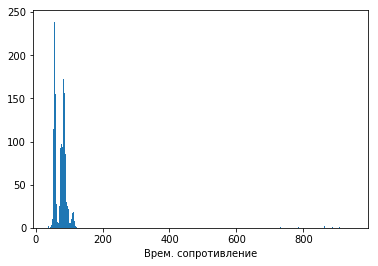

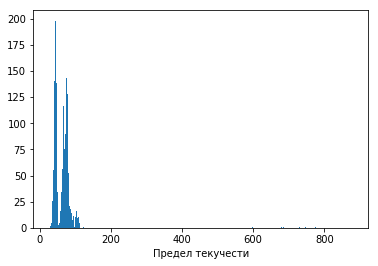

In [47]:
for col in y:
    xp = y[col].value_counts().index
    yp = y[col].value_counts().values
    plt.bar(xp, yp)
    plt.xlabel(col)
    plt.show()

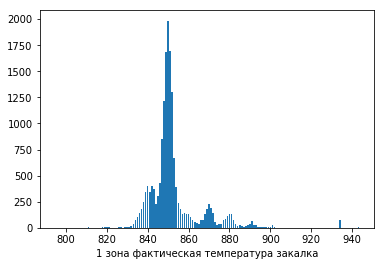

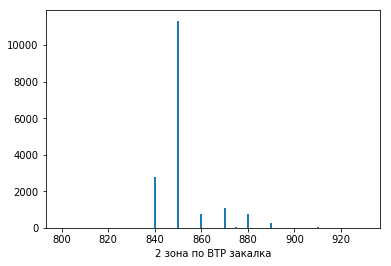

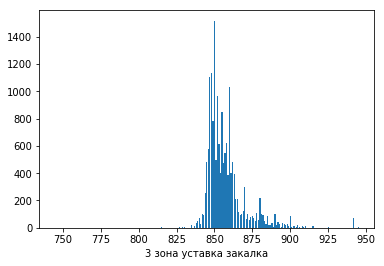

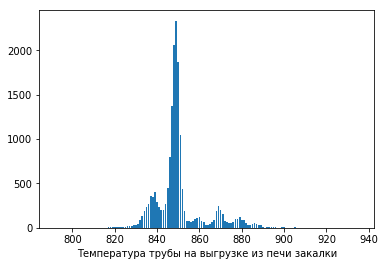

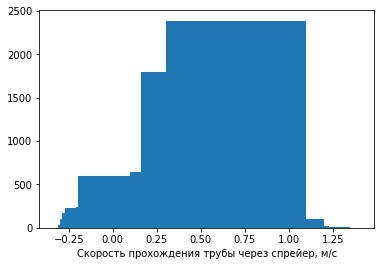

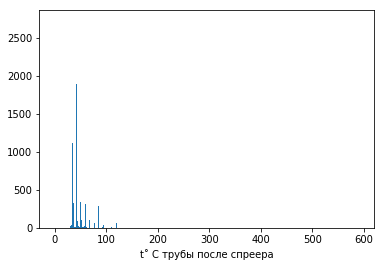

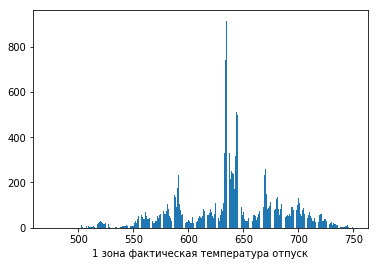

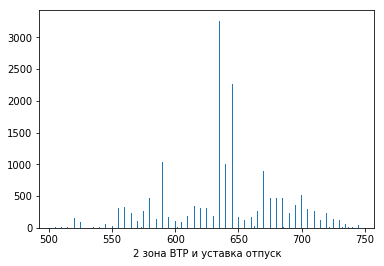

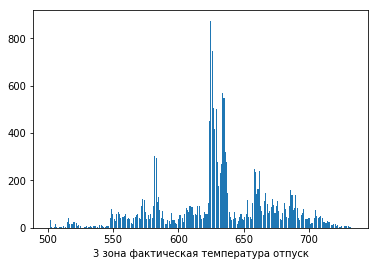

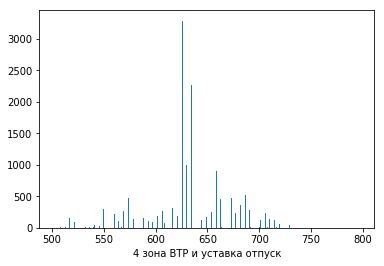

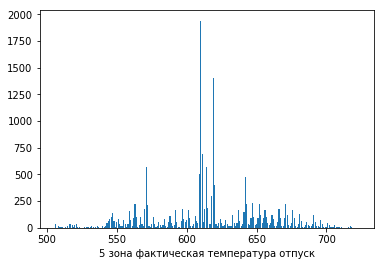

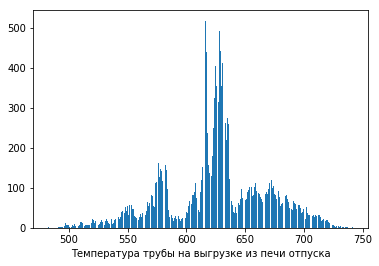

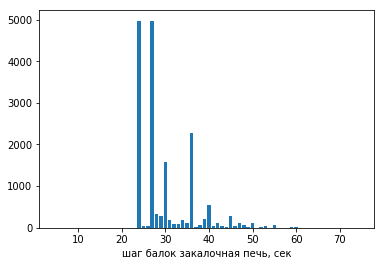

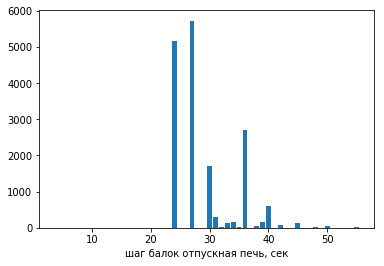

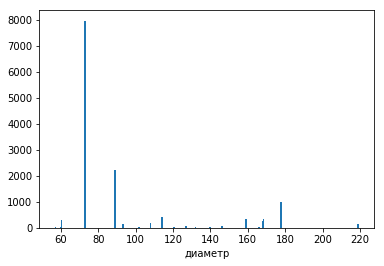

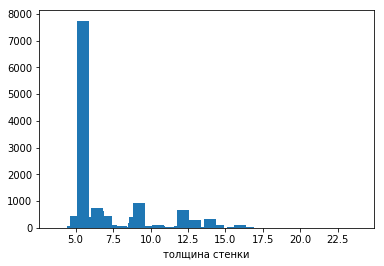

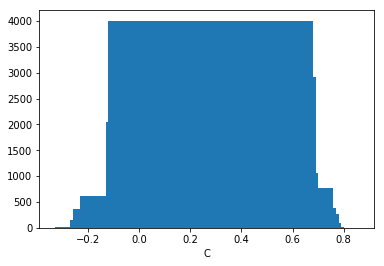

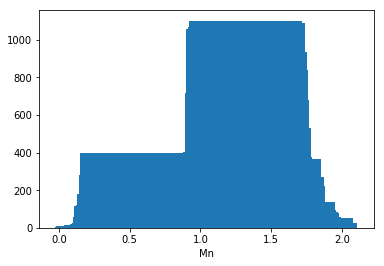

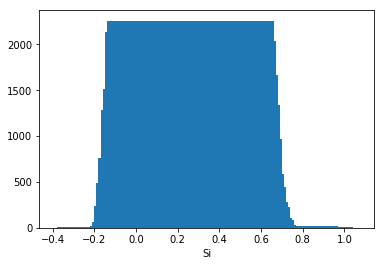

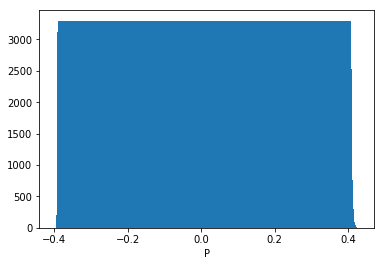

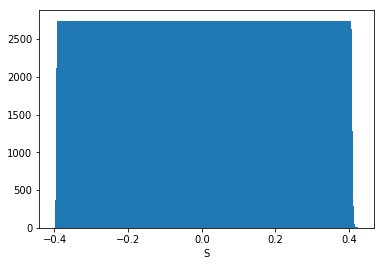

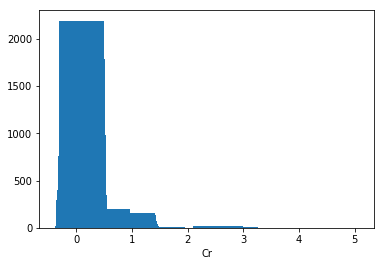

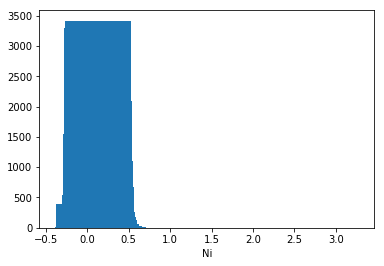

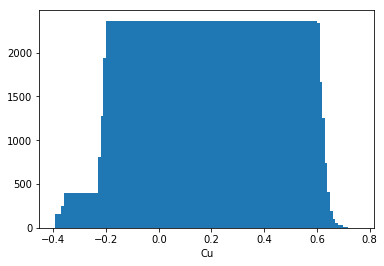

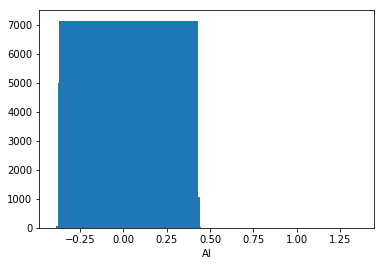

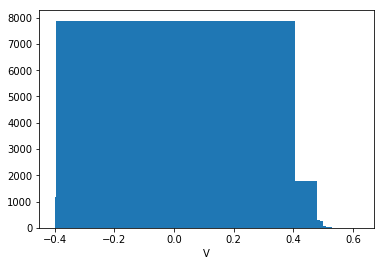

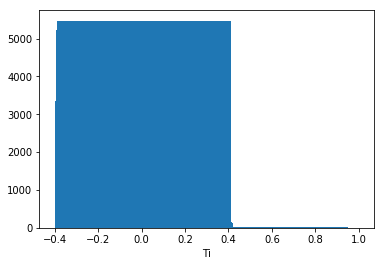

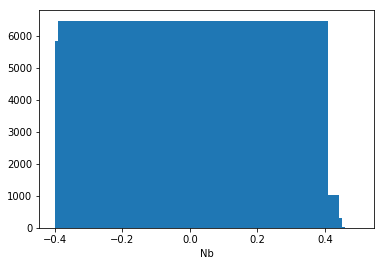

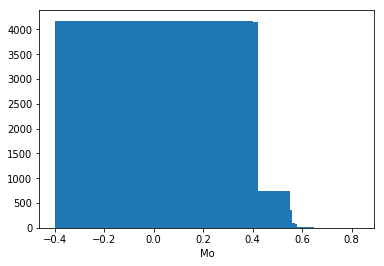

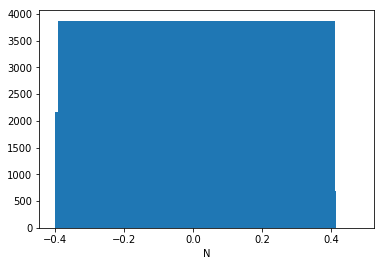

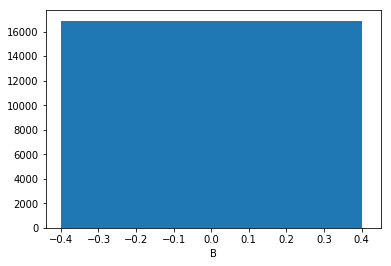

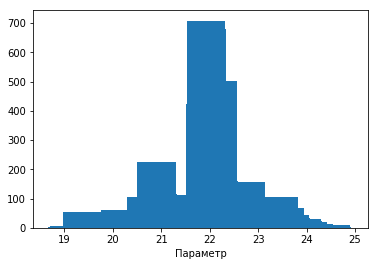

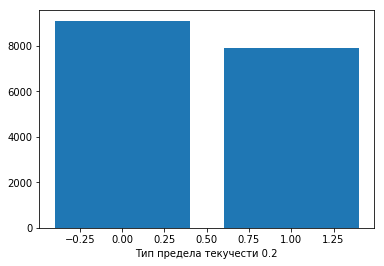

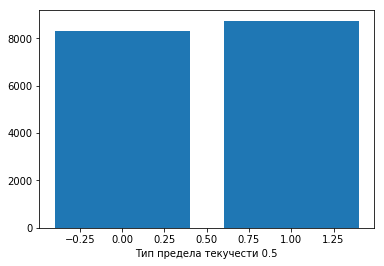

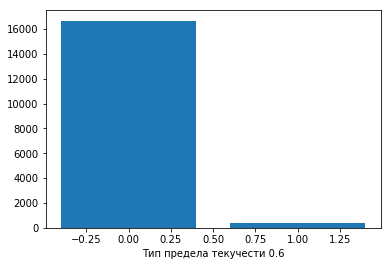

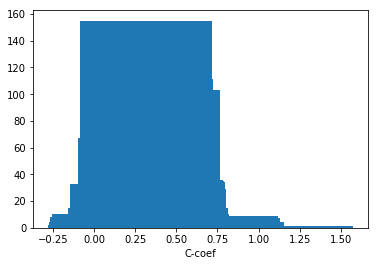

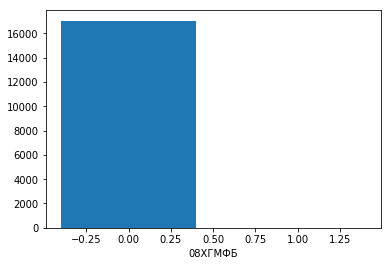

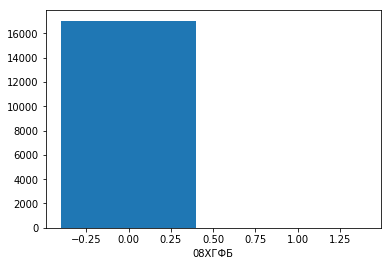

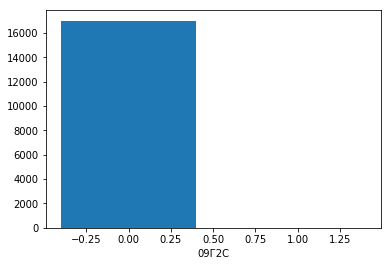

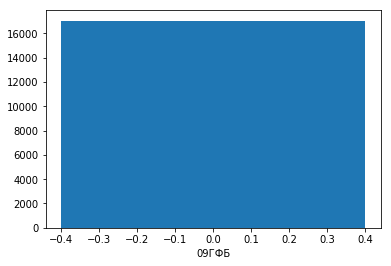

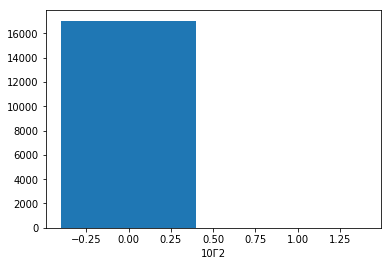

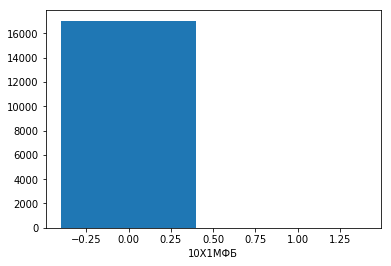

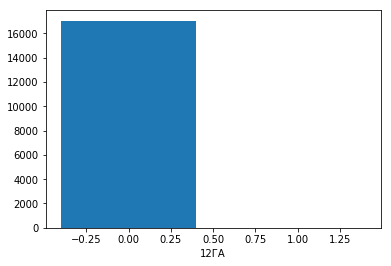

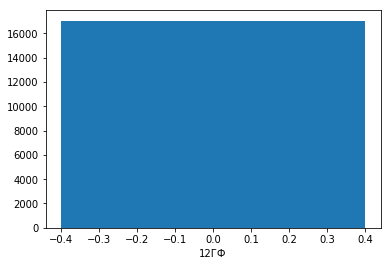

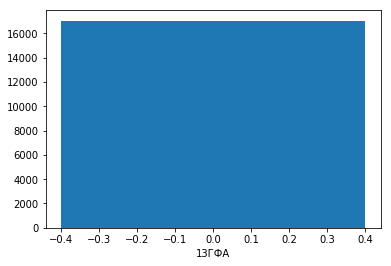

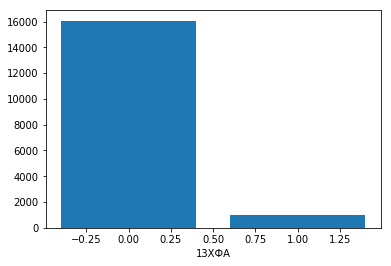

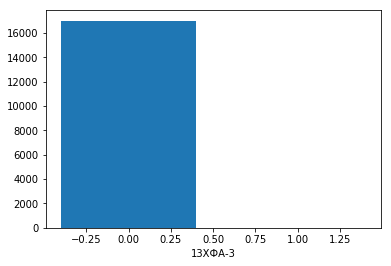

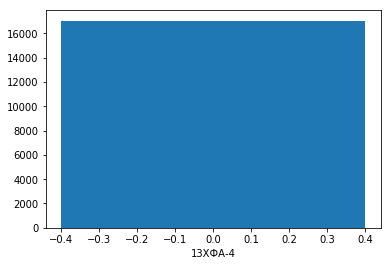

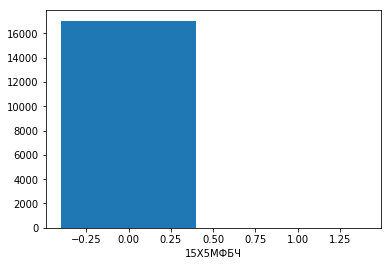

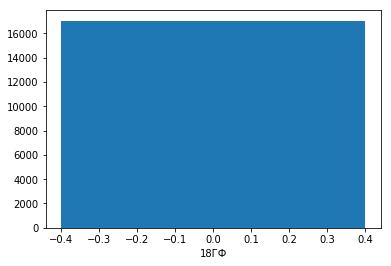

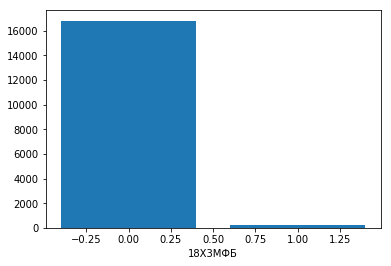

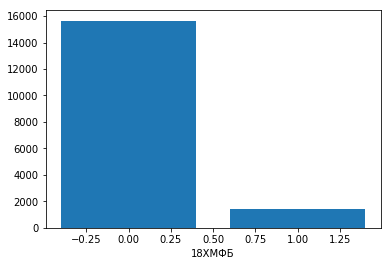

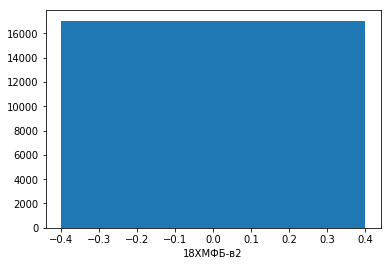

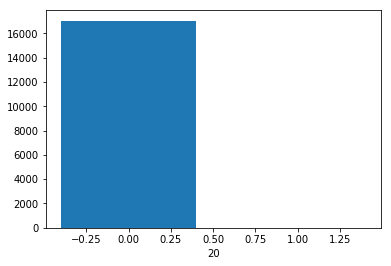

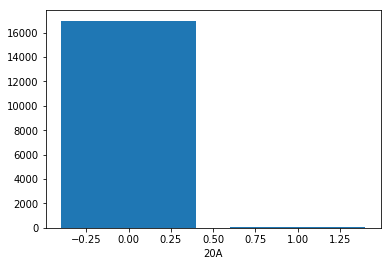

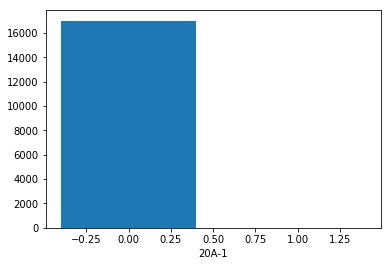

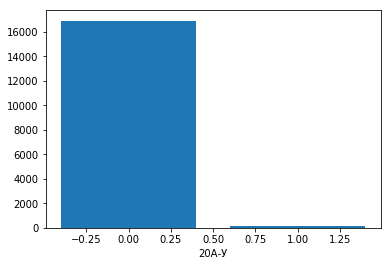

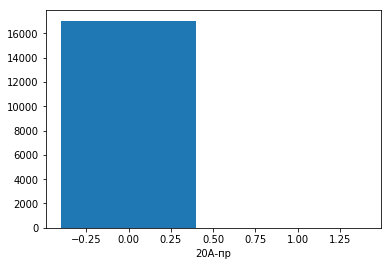

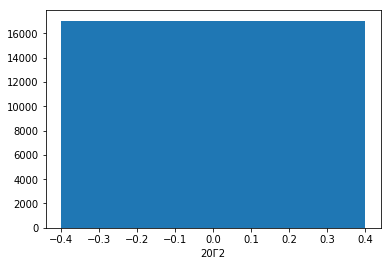

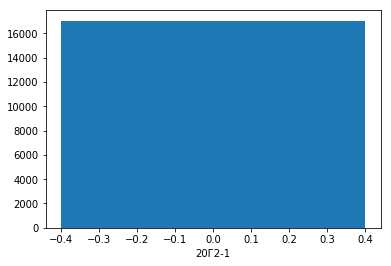

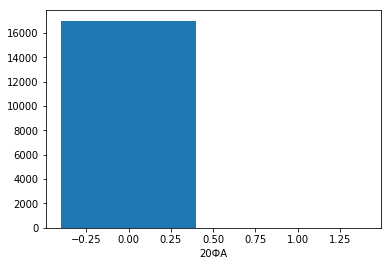

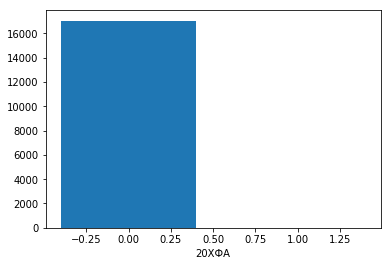

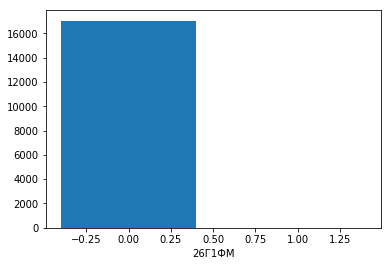

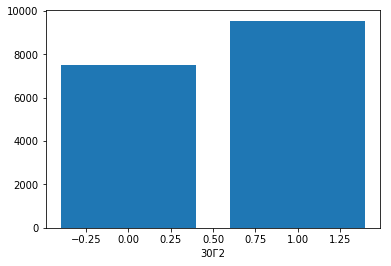

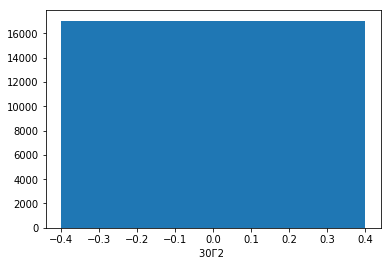

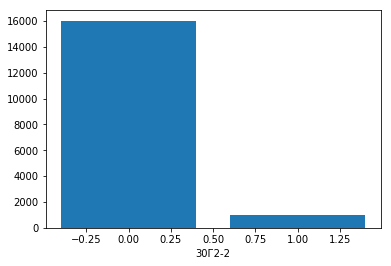

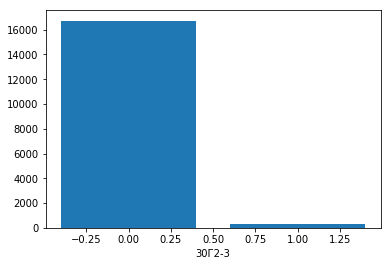

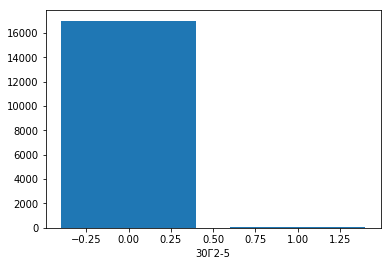

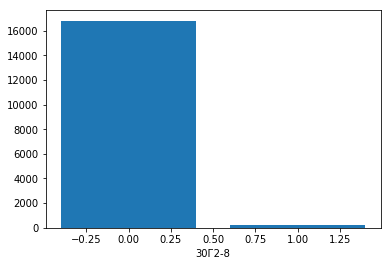

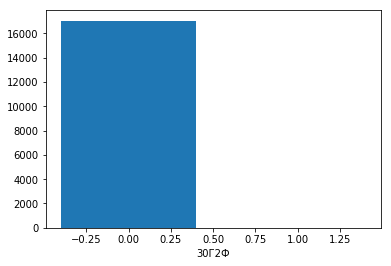

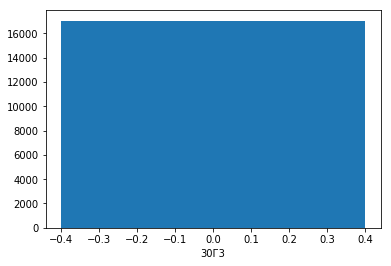

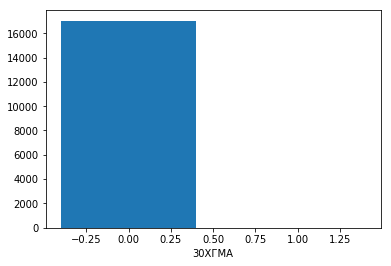

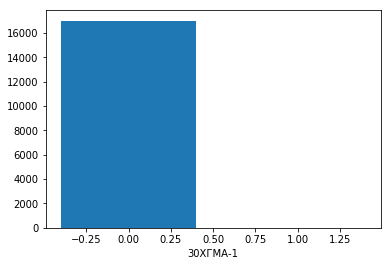

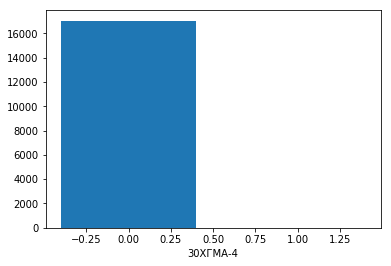

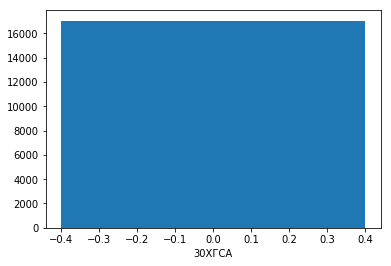

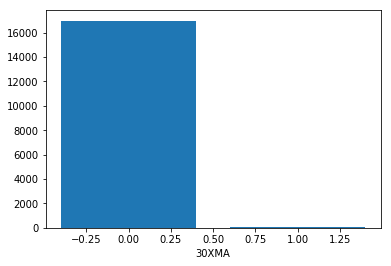

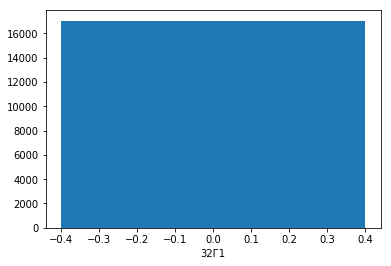

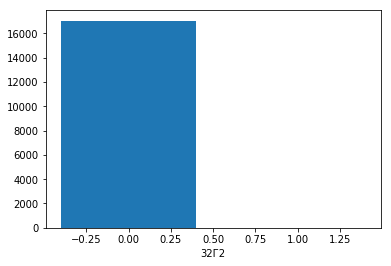

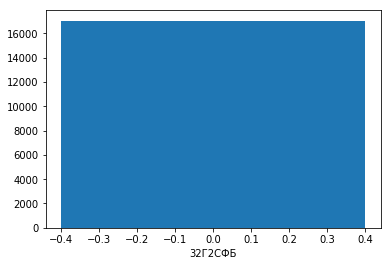

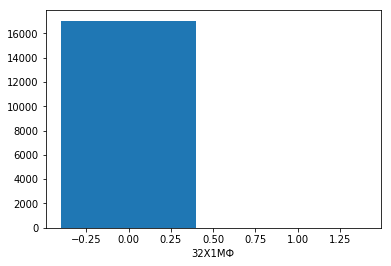

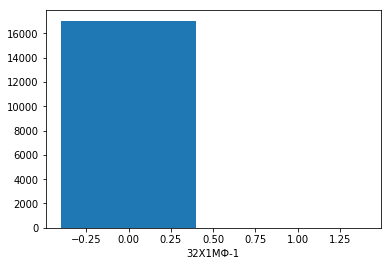

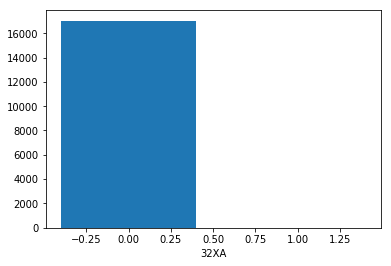

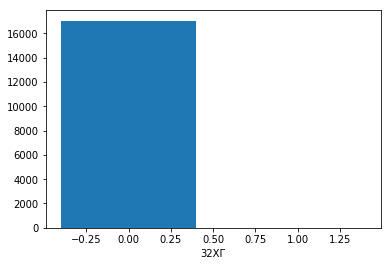

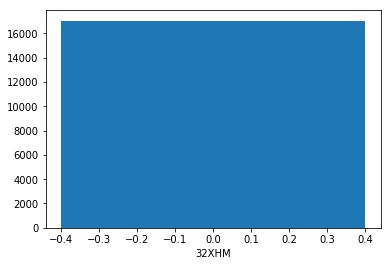

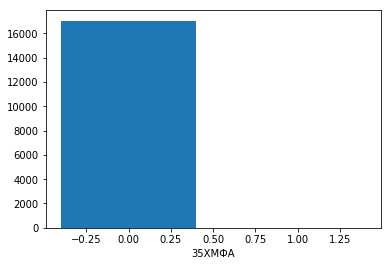

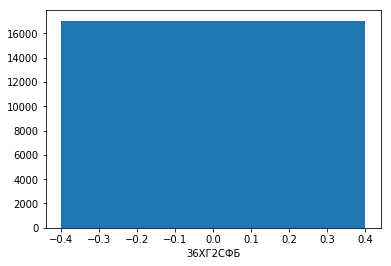

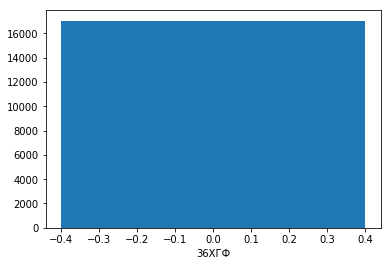

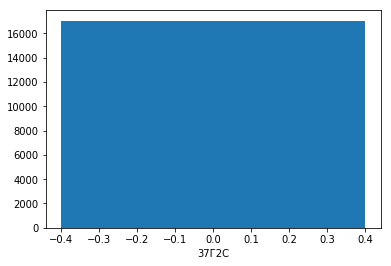

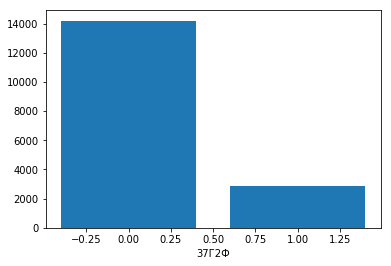

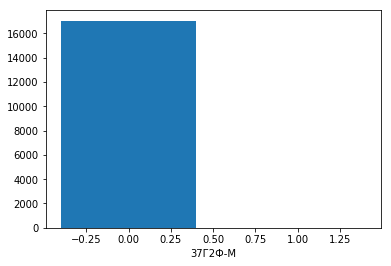

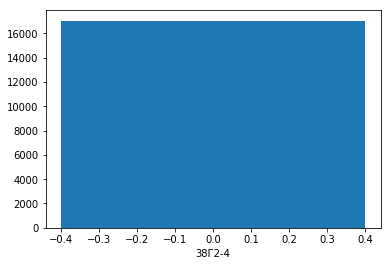

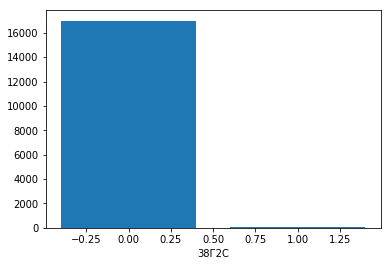

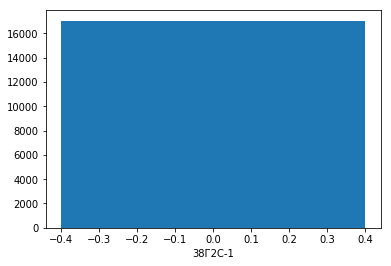

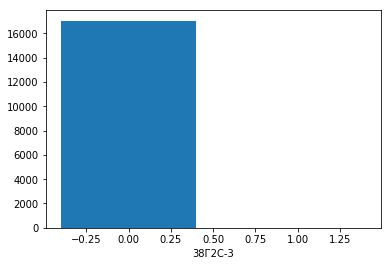

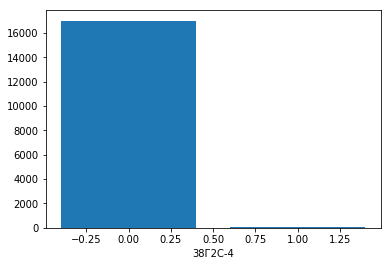

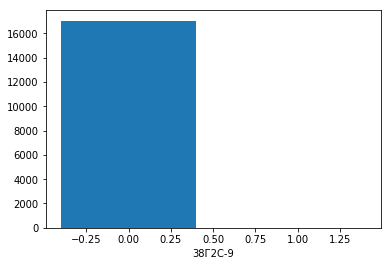

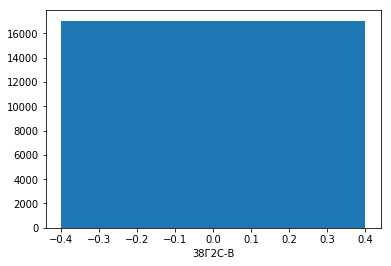

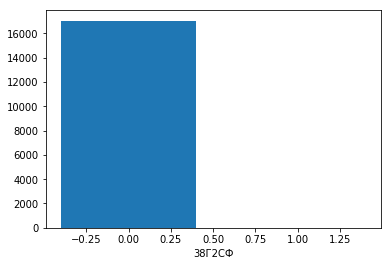

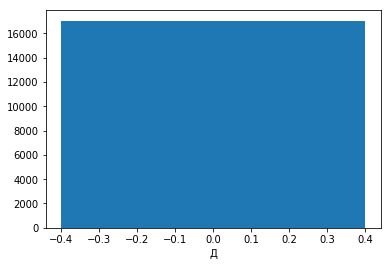

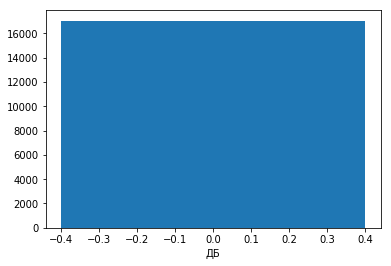

In [63]:
tmp = pd.DataFrame()
# for col in X.columns[:1]:
tmp = X[X['2 зона по ВТР закалка'] != (np.median(X['2 зона по ВТР закалка'])+50)]
for col in tmp:
    x = tmp[col].value_counts().index
    y = tmp[col].value_counts().values
    plt.bar(x, y)
    plt.xlabel(col)
    plt.show()

In [179]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=7)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

In [148]:
np.array(y).reshape(19545,)

array([ 77.5       ,  47.        ,  44.5       , ...,  67.40324168,
        67.5052133 ,  67.09732681])

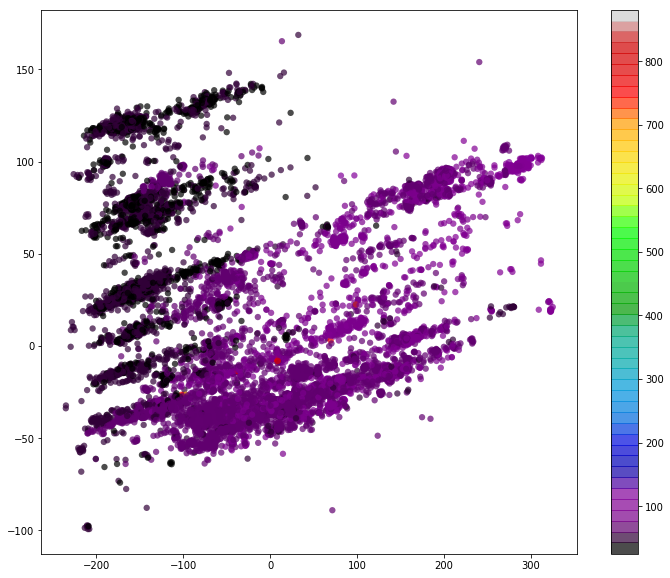

In [178]:
pca = decomposition.PCA(n_components=7)
X_reduced = pca.fit_transform(X)
plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=np.array(y).reshape(19545,),
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 50))
plt.colorbar()
plt.show()

In [163]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=np.array(y).reshape(19545,), 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. t-SNE projection')

KeyboardInterrupt: 

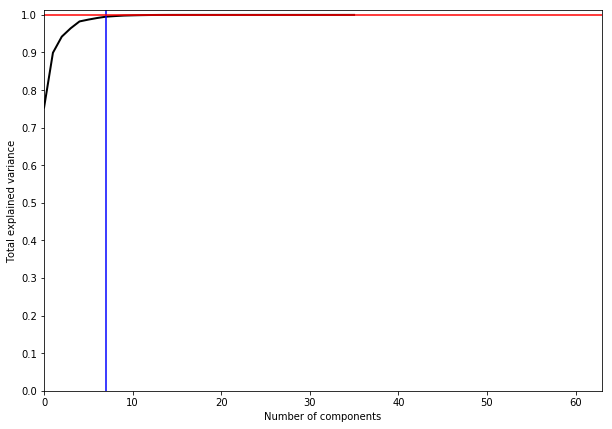

In [177]:
pca = decomposition.PCA().fit(X)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(7, c='b')
plt.axhline(1, c='r')
plt.show();

In [119]:
scalerx = StandardScaler()  

X = scalerx.fit_transform(X, y)

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2)

In [103]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((15636, 10), (15636, 1), (3909, 10), (3909, 1))

In [104]:
rfc = RandomForestRegressor(max_features = 10, max_depth = 15, min_samples_leaf = 2, n_estimators=500, random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
scr = rfc.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
corr = np.corrcoef(y_test.T, y_pred)
print(scr, mae, mse, corr)

0.520560824119 3.7055697127 206.06274577 [[ 1.          0.72308011]
 [ 0.72308011  1.        ]]


In [214]:
rfc.feature_importances_

array([  5.15572134e-02,   2.18854202e-02,   3.82401513e-02,
         3.88977594e-02,   3.91027011e-02,   5.44601268e-02,
         6.05746839e-02,   5.94411258e-02,   9.96417376e-02,
         1.51944311e-02,   1.99016764e-02,   1.80952255e-02,
         5.52479218e-02,   3.39350223e-02,   1.70306038e-02,
         1.79927128e-02,   1.67051235e-02,   2.25238378e-02,
         1.89305231e-02,   3.60869424e-02,   1.04631147e-02,
         2.15022321e-02,   9.87019586e-03,   4.70588682e-03,
         8.07757712e-03,   1.50819483e-02,   1.74484455e-04,
         6.46949439e-02,   8.35848002e-02,   2.41693319e-06,
         0.00000000e+00,   1.51629409e-03,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         4.04122122e-08,   1.35976764e-05,   2.71231388e-02,
         5.69477442e-06,   0.00000000e+00,   3.57065170e-06,
         3.53455912e-06,   1.50096748e-03,   3.68289718e-03,
         0.00000000e+00,   1.57990813e-03,   3.42299253e-04,
         5.34653332e-05,

In [215]:
etr = ExtraTreesRegressor()
etr.fit(X_train, y_train)
print(etr.feature_importances_)

[  2.76809004e-03   4.07564578e-04   3.06172879e-02   5.08640581e-02
   1.01368048e-01   3.28357102e-02   6.02210450e-02   2.68583775e-02
   1.32364069e-01   9.10515735e-03   3.30296086e-02   2.04753854e-02
   3.24665493e-03   1.53347790e-02   1.87196076e-02   1.48302721e-02
   1.97908888e-02   1.30493621e-02   1.96142723e-02   6.64768528e-02
   1.72324613e-03   1.18132083e-02   2.19305730e-03   4.86225936e-04
   6.68403933e-04   2.04308290e-02   4.14732444e-05   5.35893426e-02
   4.23647791e-02   1.84871571e-05   4.36447207e-06   1.02749678e-02
   2.26258975e-05   0.00000000e+00   1.72786160e-06   5.48092011e-07
   1.62001153e-05   2.24349564e-05   1.39521097e-01   1.44062205e-04
   0.00000000e+00   7.55023841e-06   3.25498323e-07   9.53272027e-04
   4.98356845e-03   0.00000000e+00   6.91326257e-03   1.17553103e-03
   2.82610144e-04   3.56214019e-03   2.40489878e-04   0.00000000e+00
   0.00000000e+00   4.14343569e-05   1.23788933e-05   9.48266182e-05
   1.89690310e-04   0.00000000e+00

In [221]:
tmp = pd.DataFrame()
for col in ls_need_col; #+ls_steel:
    tmp[col] = df_prepared_merge[col]

In [222]:
len(etr.feature_importances_), len(tmp.columns)

(93, 93)

In [223]:
a = sorted(zip(rfc.feature_importances_, tmp.columns))

In [224]:
for i, j in a:
    print(i,j)

0.0 08ХГМФБ
0.0 08ХГФБ
0.0 09ГФБ
0.0 10Х1МФБ
0.0 13ГФА
0.0 13ХФА-3
0.0 15Х5МФБЧ
0.0 18ГФ
0.0 18Х3МФБ
0.0 18ХМФБ
0.0 18ХМФБ-в2
0.0 20Г2-1
0.0 20ФА
0.0 30Г2 
0.0 30Г2-2
0.0 30Г2-8
0.0 30Г3
0.0 30ХГМА-4
0.0 32Г2СФБ
0.0 32ХГ
0.0 35ХМФA
0.0 36ХГФ
0.0 37Г2Ф
0.0 37Г2Ф-М
0.0 38Г2С
0.0 38Г2СФ
0.0 Д
4.04122121523e-08 09Г2С
4.43660278692e-08 36ХГ2СФБ
1.82043900171e-07 30ХГСА
7.89698316186e-07 ДБ
2.26922643058e-06 13ХФА-4
2.39476019212e-06 32Х1МФ
2.41693318501e-06 30Г2
3.09447899957e-06 26Г1ФМ
3.31692965008e-06 38Г2-4
3.534559116e-06 20А-У
3.57065169554e-06 20
3.95690401172e-06 12ГА
4.0445463413e-06 10Г2
5.05543935053e-06 38Г2С-3
5.69477441853e-06 30ХГМА
7.9220376543e-06 30ХГМА-1
9.82904543337e-06 12ГФ
1.20578544836e-05 32Х1МФ-1
1.35976764064e-05 30Г2-3
1.48142360211e-05 32Г1
1.643153037e-05 32Г2
2.15798133138e-05 20А-пр
2.34722713957e-05 20ХФА
2.70486927191e-05 38Г2С-1
4.87783674603e-05 20Г2
5.34653332257e-05 38Г2С-9
6.29410503983e-05 30Г2Ф
0.000174484454892 B
0.000342299252916 30Г2-5
0.000434154

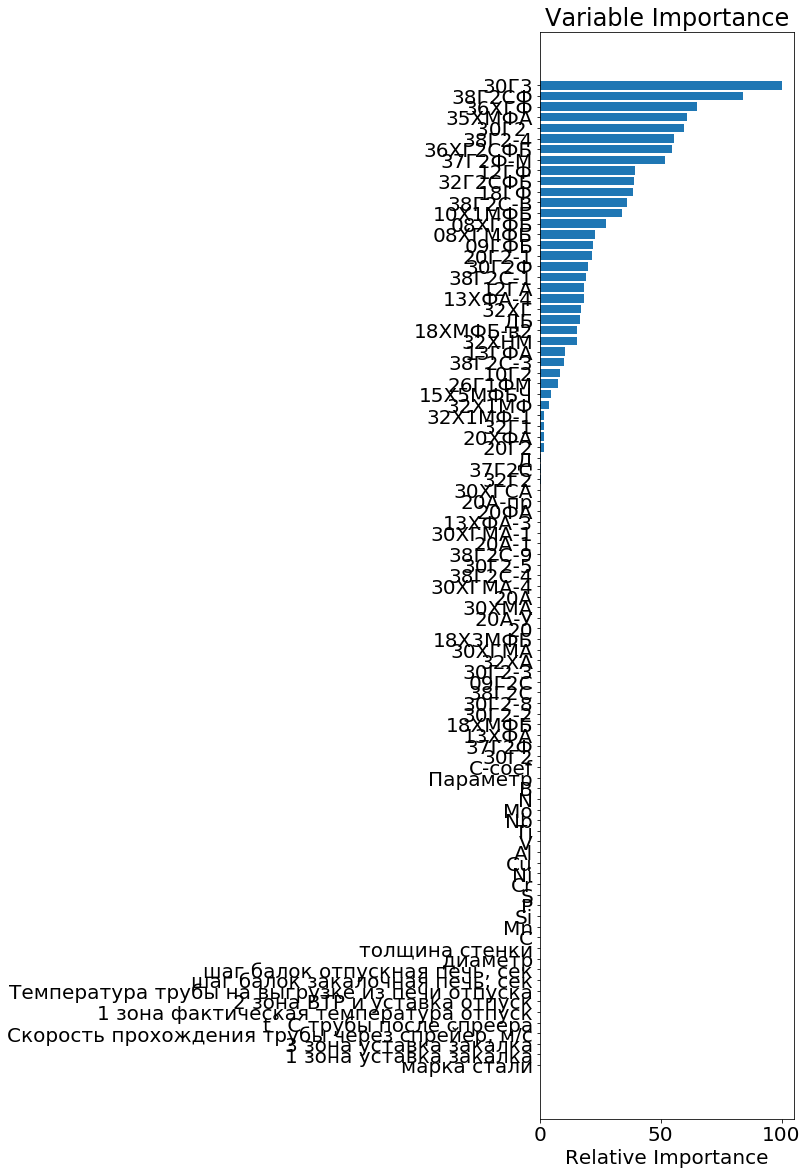

In [228]:
import matplotlib.pyplot as plt
%matplotlib inline


# plt.scatter(etr.feature_importances_, tmp.columns)

feature_importance = rfc.feature_importances_
#увеличим дефолтный размер графиков
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 20
rcParams.update({'font.size': 20})

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 2
plt.subplot(1, 2, 2)
plt.barh(pos,feature_importance[sorted_idx], align='center')
plt.yticks(pos, tmp.columns)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.savefig('feature_importance.jpg')
plt.show()


In [228]:
a = sorted(zip(fit.ranking_, tmp.columns))
for i, j in a:
    print(i,j)

1 C-coef
1 Параметр
1 шаг балок закалочная печь, сек
2 Cu
3 1 зона фактическая температура отпуск
4 C
5 t˚ C трубы после спреера
6 2 зона ВТР и уставка отпуск
7 3 зона уставка закалка
8 V
9 Температура трубы на выгрузке из печи отпуска
10 N
11 Si
12 Mn
13 1 зона уставка закалка
14 Nb
15 Скорость прохождения трубы через спрейер, м/с
16 толщина стенки
17 Cr
18 P
19 Ni
20 S
21 диаметр
22 шаг балок отпускная печь, сек
23 Mo
24 Ti
25 Al
26 B


In [232]:
from sklearn.feature_selection import RFE

etr = ExtraTreesRegressor()

rfe = RFE(etr, 3, verbose=1)

fit = rfe.fit(X_train, y_train)

print(fit.n_features_)

print(fit.support_)

print(fit.ranking_)

Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
3
[False False False False False False False  True False False False False
 False False False False False 

In [225]:
print(fit.n_features_)
print(fit.support_)
print(fit.ranking_)

3
[False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False  True  True]
[13  7 15  5  3  6  9  1 22 21 16  4 12 11 18 20 17 19  2 25  8 24 14 23 10
 26  1  1]


In [276]:
# cv = cross_val_score(rfc, X, y, cv=5, scoring = 'neg_median_absolute_error')

In [277]:
# np.mean(cv)

In [305]:
# predicted = cross_val_predict(rfc, X, y, cv=5)

In [306]:
# mae = mean_absolute_error(y, predicted)
# mae

In [155]:
mae*9.8

29.316895263172619

In [309]:
'''
Подбор параметров деревьев решений
'''
from sklearn.model_selection import GridSearchCV

tree = RandomForestRegressor()

tree_params = {'max_depth': range(5,15, 5),'max_features': range(10,20),  
               'min_samples_leaf': range(1,4), 'n_estimators': range(100,1000, 300)}

tree_grid = GridSearchCV(tree, tree_params,cv=5, verbose = True, n_jobs=-1)

tree_grid.fit(X_train, y_train)
y_pred_grid = tree_grid.predict(X_test)
print(tree_grid.best_params_)
print(tree_grid.best_score_)
print(mean_absolute_error(y_test, y_pred_grid))

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 25.9min finished


{'max_depth': 5, 'max_features': 18, 'min_samples_leaf': 1, 'n_estimators': 100}
0.462801575777
4.12002750959


In [784]:
'''

ЗАПИСЬ МОДЕЛИ В ФАЙЛ

'''


import pickle
pickle.dump(rfc, open('model_текучесть 736.sav', 'wb'))
# tree_grid2 = pickle.load(open('model_текучесть 0.45r 570.sav', 'rb'))

In [86]:
d = {
#     'НД (гост, ту)' : [ ]
#     'марка стали' : [35, 52, 27], #'30ХГМА', '37Г2Ф', '30Г2'
#     '1 зона фактическая температура закалка' : [860, 840, 850], 
#     '2 зона по ВТР закалка' : [860, 840, 850],
    '3 зона по ВТР закалка' : [860, 850, 860], 
    'Температура трубы на выгрузке из печи закалки' : [855, 835, 850],
    'Скорость прохождения трубы через спрейер, м/с' : [0.15, 0.28, 0.37],
    't˚ C трубы после спреера' : [106, 100, 75],
    '1 зона ВТР и уставка отпуск' : [675, 664, 600], 
    '2 зона ВТР и уставка отпуск' : [675, 664, 600], 
    '3 зона ВТР и уставка отпуск' : [650, 653, 593],
    '4 зона ВТР и уставка отпуск' : [650, 653, 593],
    '5 зона ВТР и уставка отпуск' : [633, 637, 580], 
    'Температура трубы на выгрузке из печи отпуска' : [660, 660, 575],
    'шаг балок закалочная печь, сек' : [37, 40, 30], 
    'шаг балок отпускная печь, сек' : [37, 31, 30],
    'диаметр' : [187.71, 88.9, 168.28], 
    'толщина стенки' : [16.5, 12.2, 8.94], 
    'C' : [0.29, 0.37, 0.28], 
    'Mn' : [0.92, 1.49, 1.33], 
    'Si' : [0.26, 0.28, 0.26], 
    'P' : [0.009, 0.011, 0.009], 
    'S' : [0.005, 0.007, 0.007],
    'Cr' : [0.68, 0.14, 0.1], 
    'Ni' : [0.13, 0.13, 0.13], 
    'Cu' : [0.15, 0.13, 0.19], 
    'Al' : [0.03, 0.03, 0.03], 
    'V' : [0.007, 0.09, 0.005], 
    'Ti' : [0, 0.006, 0.007], 
    'Nb' : [0, 0.0002, 0.006], 
    'Mo' : [0.16, 0.0009, 0.015], 
    'N' : [0.008, 0.006, 0.009], 
    'B': [0, 0, 0.0005],
    'Параметр' : [20.31, 20.17, 18.89],
    'Тип предела текучести 0.2': [1, 1, 1],
    'Тип предела текучести 0.5': [0, 0, 0],
    'Тип предела текучести 0.6': [0, 0, 0],
    'C-coef': [0.39, 0.37, 0.31],
    '08ХГМФБ': [0, 0, 0],
    '08ХГФБ': [0, 0, 0],
    '09Г2С': [0, 0, 0],
    '09ГФБ': [0, 0, 0],
    '10Г2': [0, 0, 0],
    '10Х1МФБ': [0, 0, 0],
    '12ГА': [0, 0, 0],
    '12ГФ': [0, 0, 0],
    '13ГФА': [0, 0, 0],
    '13ХФА': [0, 0, 0],
    '13ХФА-3': [0, 0, 0],
    '13ХФА-4': [0, 0, 0],
    '15Х5МФБЧ': [0, 0, 0],
    '18ГФ': [0, 0, 0],
    '18Х3МФБ': [0, 0, 0],
    '18ХГТ': [0, 0, 0],
    '18ХМФБ': [0, 0, 0],
    '18ХМФБ-в2': [0, 0, 0],
    '20': [0, 0, 0],
    '20А': [0, 0, 0],
    '20А-1': [0, 0, 0],
    '20А-У': [0, 0, 0],
    '20А-пр': [0, 0, 0],
    '20Г2': [0, 0, 0],
    '20Г2-1': [0, 0, 0],
    '20ФА': [0, 0, 0],
    '20ХМФА': [0, 0, 0],
    '20ХФА': [0, 0, 0],
    '26Г1ФМ': [0, 0, 0],
    '30Г2': [0, 0, 1],
    '30Г2 ': [0, 0, 0],
    '30Г2-2': [0, 0, 0],
    '30Г2-3': [0, 0, 0],
    '30Г2-5': [0, 0, 0],
    '30Г2-8': [0, 0, 0],
    '30Г2Ф': [0, 0, 0],
    '30Г3': [0, 0, 0],
    '30ХГМА': [1, 0, 0],
    '30ХГМА-1': [0, 0, 0],
    '30ХГМА-4': [0, 0, 0],
    '30ХГСА': [0, 0, 0],
    '30ХМА': [0, 0, 0],
    '32Г1': [0, 0, 0],
    '32Г2': [0, 0, 0],
    '32Г2СФБ': [0, 0, 0],
    '32Х1МФ': [0, 0, 0],
    '32Х1МФ-1': [0, 0, 0],
    '32ХА': [0, 0, 0],
    '32ХГ': [0, 0, 0],
    '32ХНМ': [0, 0, 0],
    '35ХМФA': [0, 0, 0],
    '36ХГ2СФБ': [0, 0, 0],
    '36ХГФ': [0, 0, 0],
    '37Г2С': [0, 0, 0],
    '37Г2Ф': [0, 1, 0],
    '37Г2Ф-М': [0, 0, 0],
    '38Г2-4': [0, 0, 0],
    '38Г2С': [0, 0, 0],
    '38Г2С-1': [0, 0, 0],
    '38Г2С-3': [0, 0, 0],
    '38Г2С-4': [0, 0, 0],
    '38Г2С-9': [0, 0, 0],
    '38Г2С-В': [0, 0, 0],
    '38Г2СФ': [0, 0, 0],
    'Д': [0, 0, 0],
    'ДБ': [0, 0, 0]
}

df = pd.DataFrame(data=d)

In [87]:
import pickle

s = pickle.dumps(rfc)
rfc2 = pickle.loads(s)
y = rfc2.predict(df)
print(y*9.8)

ValueError: Number of features of the model must match the input. Model n_features is 2 and input n_features is 100 

In [308]:
y[0]

70.575424460063118

In [309]:
s = pickle.dumps(tree_grid)
rfc2 = pickle.loads(s)
y = rfc2.predict(df)
print(y*9.8)

NameError: name 'tree_grid' is not defined

In [314]:
import theano

In [391]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization

kfold = model_selection.KFold(n_splits=5, random_state=17)

model = Sequential()
model.add(Dense(units=3, input_dim=X.shape[1]))
model.add(Activation('sigmoid'))
# model.add(Dropout(0.3))
# model.add(Dense(units=4))
# model.add(Activation('tanh'))
# model.add(Dropout(0.4))
# model.add(Dense(units=4))
# model.add(Activation('sigmoid'))

model.add(Dense(units=1))

model.compile(
    loss=keras.losses.mean_squared_error,
    # loss=keras.losses.mean_absolute_error,
    metrics=[keras.metrics.mean_absolute_error],
    optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.5, decay=1e-1)
    )

model.fit(X_train, y_train, batch_size = 512, epochs=500)

# cv_results = model_selection.cross_val_score(svr,X_train, np.ravel(y_train), cv=kfold, scoring='r2')

Epoch 1/500
16613/16613 [==============================] - 1s 76us/step - loss: 1509.0157 - mean_absolute_error: 26.0331
Epoch 2/500
16613/16613 [==============================] - 0s 12us/step - loss: 511.5515 - mean_absolute_error: 6.7675
Epoch 3/500
16613/16613 [==============================] - 0s 10us/step - loss: 485.3653 - mean_absolute_error: 5.66630s - loss: 297.7649 - mean_absolute_error: 5.5
Epoch 4/500
16613/16613 [==============================] - 0s 10us/step - loss: 479.6052 - mean_absolute_error: 5.6246
Epoch 5/500
16613/16613 [==============================] - 0s 10us/step - loss: 477.4594 - mean_absolute_error: 5.6731
Epoch 6/500
16613/16613 [==============================] - 0s 10us/step - loss: 476.3767 - mean_absolute_error: 5.7165
Epoch 7/500
16613/16613 [==============================] - 0s 10us/step - loss: 475.7034 - mean_absolute_error: 5.7506
Epoch 8/500
16613/16613 [==============================] - 0s 10us/step - loss: 475.2130 - mean_absolute_error: 5.7647


16613/16613 [==============================] - 0s 4us/step - loss: 456.7973 - mean_absolute_error: 4.8774
Epoch 137/500
16613/16613 [==============================] - 0s 4us/step - loss: 456.7521 - mean_absolute_error: 4.8747
Epoch 138/500
16613/16613 [==============================] - 0s 4us/step - loss: 456.7056 - mean_absolute_error: 4.8725
Epoch 139/500
16613/16613 [==============================] - 0s 4us/step - loss: 456.6590 - mean_absolute_error: 4.8695
Epoch 140/500
16613/16613 [==============================] - 0s 4us/step - loss: 456.6118 - mean_absolute_error: 4.8672
Epoch 141/500
16613/16613 [==============================] - 0s 3us/step - loss: 456.5639 - mean_absolute_error: 4.8644
Epoch 142/500
16613/16613 [==============================] - 0s 4us/step - loss: 456.5152 - mean_absolute_error: 4.8618
Epoch 143/500
16613/16613 [==============================] - 0s 4us/step - loss: 456.4664 - mean_absolute_error: 4.8590
Epoch 144/500
16613/16613 [===========================

16613/16613 [==============================] - 0s 4us/step - loss: 451.4587 - mean_absolute_error: 4.5480
Epoch 272/500
16613/16613 [==============================] - 0s 4us/step - loss: 451.4324 - mean_absolute_error: 4.5465
Epoch 273/500
16613/16613 [==============================] - 0s 4us/step - loss: 451.4078 - mean_absolute_error: 4.5456
Epoch 274/500
16613/16613 [==============================] - 0s 4us/step - loss: 451.3839 - mean_absolute_error: 4.5443
Epoch 275/500
16613/16613 [==============================] - 0s 4us/step - loss: 451.3598 - mean_absolute_error: 4.5431
Epoch 276/500
16613/16613 [==============================] - 0s 4us/step - loss: 451.3341 - mean_absolute_error: 4.5429
Epoch 277/500
16613/16613 [==============================] - 0s 4us/step - loss: 451.3107 - mean_absolute_error: 4.5417
Epoch 278/500
16613/16613 [==============================] - 0s 4us/step - loss: 451.2868 - mean_absolute_error: 4.5402
Epoch 279/500
16613/16613 [===========================

16613/16613 [==============================] - 0s 3us/step - loss: 448.9550 - mean_absolute_error: 4.4429
Epoch 407/500
16613/16613 [==============================] - 0s 3us/step - loss: 448.9400 - mean_absolute_error: 4.4423
Epoch 408/500
16613/16613 [==============================] - 0s 3us/step - loss: 448.9259 - mean_absolute_error: 4.4416
Epoch 409/500
16613/16613 [==============================] - 0s 3us/step - loss: 448.9112 - mean_absolute_error: 4.4409
Epoch 410/500
16613/16613 [==============================] - 0s 3us/step - loss: 448.8978 - mean_absolute_error: 4.4404
Epoch 411/500
16613/16613 [==============================] - 0s 3us/step - loss: 448.8828 - mean_absolute_error: 4.4398
Epoch 412/500
16613/16613 [==============================] - 0s 3us/step - loss: 448.8681 - mean_absolute_error: 4.4394
Epoch 413/500
16613/16613 [==============================] - 0s 3us/step - loss: 448.8530 - mean_absolute_error: 4.4387
Epoch 414/500
16613/16613 [===========================

In [392]:
y_predict = model.predict(X_test)
mae = mean_absolute_error(y_predict, y_test)
print(mae)

4.50946656305


In [394]:
# model.save('kerasNN 715 715 651.h5')
y = model.predict(df)
print(y*9.8)

[[ 556.34490967]
 [ 556.34490967]
 [ 556.34490967]]


In [255]:
from keras.models import load_model

test = load_model('kerasNN 715 715 651.h5')
y = test.predict(df)
print(y*9.8)

[[ 693.77380371]
 [ 693.77380371]
 [ 694.08398438]]


In [22]:
import pydot
import graphviz

ModuleNotFoundError: No module named 'graphviz'

In [21]:
from keras.utils import plot_model

plot_model(model)

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [325]:
df_prepared_merge.columns

Index(['марка стали', '1 зона фактическая температура закалка',
       '3 зона фактическая температура закалка',
       'Температура трубы на выгрузке из печи закалки',
       'Скорость прохождения трубы через спрейер, м/с',
       '1 зона фактическая температура отпуск',
       '3 зона фактическая температура отпуск',
       '5 зона фактическая температура отпуск',
       'Температура трубы на выгрузке из печи отпуска',
       'шаг балок закалочная печь, сек', 'шаг балок отпускная печь, сек',
       'диаметр', 'толщина стенки', 'C', 'Mn', 'Si', 'P', 'S', 'Cr', 'Ni',
       'Cu', 'Al', 'V', 'Ti', 'Nb', 'Mo', 'N', 'B', 'Параметр', 'C-coef',
       'Предел текучести', 'Врем. сопротивление'],
      dtype='object')

In [327]:
len(df_prepared_merge['марка стали'].value_counts())

50

In [8]:
df_prepared_merge.columns[:2]

Index(['марка стали', '1 зона фактическая температура закалка'], dtype='object')

марка стали


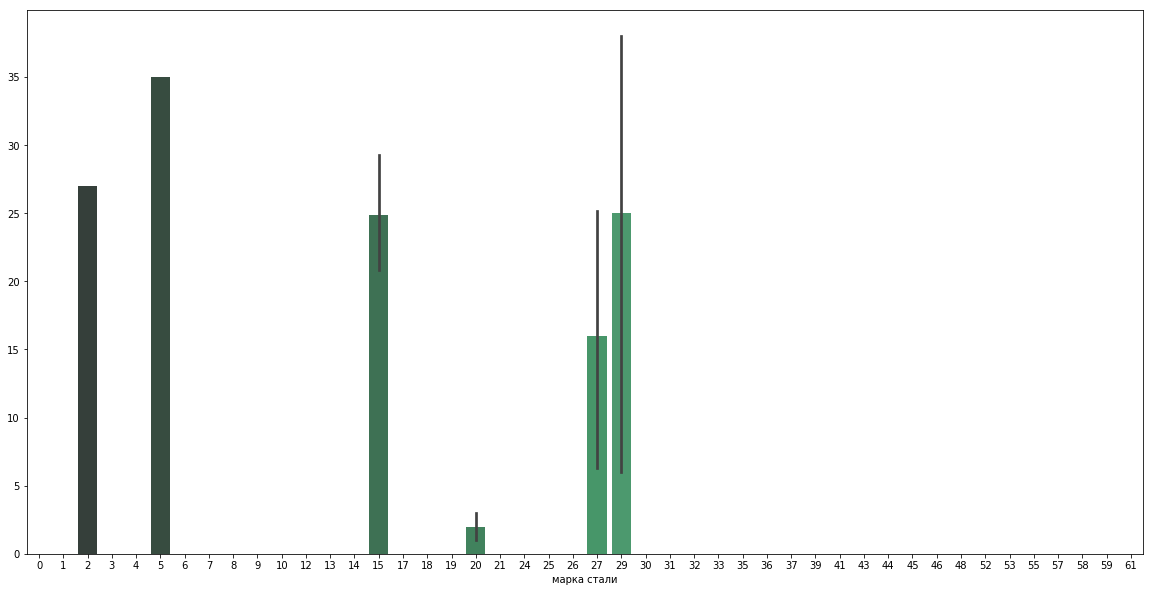

In [303]:
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline


#увеличим дефолтный размер графиков
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10

for col in df_prepared_merge.columns[:1]:
    print(col)
    x = df_prepared_merge[col]
    y1 = range(0, len(df_prepared_merge[col].value_counts()))
    sns.barplot(x, y1, palette="BuGn_d")


In [20]:
# '''
# SVR
# '''

# C=1.0
# ratio = 0.9
# seed=17
# epsilon=0.3

# svr_eps = LinearSVR(C = C)

# kfold = model_selection.KFold(n_splits=5, random_state=seed)

# t0 = time.time()
# cv_results = model_selection.cross_val_score(svr_eps, 
#                                              X_train, np.ravel(y_train), cv=kfold, scoring='r2')
# t1 = time.time() - t0
# print(cv_results.mean())
# print(t1)

0.174145449437
13.475857973098755


In [21]:
# '''
# Подбор параметров деревьев решений
# '''
# from sklearn.model_selection import GridSearchCV

# tree = DecisionTreeRegressor()

# tree_params = {'max_depth': range(10,30),'max_features': range(5,20)}

# tree_grid = GridSearchCV(tree, tree_params,cv=5, verbose = True)

# tree_grid.fit(X_train, y_train)
# y_pred_grid = tree_grid.predict(X_test)
# print(tree_grid.best_params_)
# print(tree_grid.best_score_)
# print(mean_absolute_error(y_test, y_pred_grid))

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
{'max_depth': 22, 'max_features': 16}
0.184346892408
3.51187157972


[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:  2.2min finished


In [22]:
# '''
# Дерево решений
# '''
# tree = DecisionTreeRegressor(max_depth = tree_grid.best_params_['max_depth'], max_features = tree_grid.best_params_['max_features'])
# tree.fit(X_train, y_train)

# y_predicted = tree.predict(X_test)

# scr = tree.score(X_test, y_test)
# mae = mean_absolute_error(y_test, y_predicted)
# print(scr, mae)

-4.02904439516 4.18616107758


In [24]:
# forest = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=17)
# print(np.mean(cross_val_score(forest, X_train, y_train, cv=5)))

# forest_params = {'max_depth': range(1,11), 'max_features': range(4,19)}

# forest_grid = GridSearchCV(forest, forest_params, cv=5, verbose=True)

# forest_grid.fit(X_train, y_train)
# y_pred_grid = forest_grid.predict(X_test)
# print(forest_grid.best_params_)
# print(forest_grid.best_score_)
# print(mean_absolute_error(y_test, y_pred_grid))

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

0.324043674676
Fitting 5 folds for each of 150 candidates, totalling 750 fits


C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed: 17.2min finished
C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'max_depth': 8, 'max_features': 6}
0.465330919591
2.83069259541


In [25]:
# forest = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=17)
# tree = DecisionTreeRegressor(max_depth = forest_grid.best_params_['max_depth'], 
#                              max_features = forest_grid.best_params_['max_features'])
# estimators = [
#     forest,
#     tree
# ]

# for est in estimators:
#     bagging = BaggingRegressor(est,n_estimators=100, bootstrap=True, bootstrap_features=True)

#     bagging.fit(X_train, y_train)
#     y_pred = bagging.predict(X_test)
#     scr = bagging.score(X_test, y_test)
#     mae = mean_absolute_error(y_test, y_pred)
#     print(scr, mae)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.307558494245 2.67651568369


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.364780510816 2.89249337515


In [26]:
# # Сделаем инициализацию параметров, по которым хотим сделать полный перебор
# parameters = {'max_features': [12,15], 'min_samples_leaf': [2,3], 'max_depth': [12,15], 
#               'n_estimators':[500,1000]}
# rfc = RandomForestRegressor(random_state=42, 
#                              n_jobs=-1, oob_score=True)
# gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=5, verbose=1)
# gcv.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  6.0min finished
C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': [12, 15], 'min_samples_leaf': [2, 3], 'max_depth': [12, 15], 'n_estimators': [500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [27]:
# y_predicted = gcv.predict(X_test)

# mae = mean_absolute_error(y_test, y_predicted)
# mse = mean_squared_error(y_test, y_predicted)
# print(gcv.best_estimator_, 'r2 = ', gcv.best_score_, 'mae = ', mae, 'mse =', mse)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features=12, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=True, random_state=42,
           verbose=0, warm_start=False) r2 =  0.428224853422 mae =  2.62984821274 mse = 185.823787831


array([[ 1.00413529,  1.00263618,  1.00695396, ..., -0.52750024,
         0.40814083, -0.06939041],
       [ 1.99542635,  1.99366535,  1.99427932, ...,  2.61139254,
         0.13907012, -0.06939041],
       [-0.4828013 , -0.48390756, -0.47403409, ..., -0.31824072,
        -0.1300006 , -0.06939041],
       ..., 
       [-0.4828013 , -0.48390756, -0.47403409, ..., -0.1089812 ,
        -2.0134956 , -0.06939041],
       [ 1.99542635,  1.99366535,  1.99427932, ...,  2.82065206,
         0.67721155, -0.06939041],
       [-0.4828013 , -0.48390756, -0.47403409, ...,  0.10027832,
         0.67721155, -0.06939041]])

In [ ]:
NN = MLPRegressor(hidden_layer_sizes=(50, 16), activation='tanh', solver='sgd', 
                  alpha=0.01, batch_size=512, learning_rate='adaptive', 
                  learning_rate_init=0.01, power_t=0.7, 
                  max_iter=10000, tol=1e-15, verbose=True)

NN.fit(X_train, y_train)

y_pred = NN.predict(X_test)

scr = NN.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
print(scr, mae)

In [ ]:
X_train.shape

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization

kfold = model_selection.KFold(n_splits=5, random_state=seed)

model = Sequential()
model.add(Dense(units=8, input_dim=X.shape[1]))
model.add(Activation('sigmoid'))
# model.add(Dropout(0.4))
# model.add(Dense(units=8, input_dim=X.shape[1]))
# model.add(Activation('sigmoid'))

# model.add(Dense(units=4))
# model.add(Activation('sigmoid'))

model.add(Dense(units=1))

model.compile(
    loss=keras.losses.mean_squared_error,
    # loss=keras.losses.mean_absolute_error,
    metrics=[keras.metrics.mean_absolute_error],
    optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.5, decay=1e-1)
    )

model.fit(X_train, y_train, epochs=1000)

# cv_results = model_selection.cross_val_score(svr,X_train, np.ravel(y_train), cv=kfold, scoring='r2')

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization

kfold = model_selection.KFold(n_splits=5, random_state=seed)

model = Sequential()
model.add(Dense(units=8, input_dim=X.shape[1]))
model.add(Activation('sigmoid'))
# model.add(Dropout(0.4))
# model.add(Dense(units=8, input_dim=X.shape[1]))
# model.add(Activation('sigmoid'))

# model.add(Dense(units=4))
# model.add(Activation('sigmoid'))

model.add(Dense(units=1))

model.compile(
    loss=keras.losses.mean_squared_error,
    # loss=keras.losses.mean_absolute_error,
    metrics=[keras.metrics.mean_absolute_error],
    optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.5, decay=1e-1)
    )

model.fit(X_train, y_train, epochs=1000)

# cv_results = model_selection.cross_val_score(svr,X_train, np.ravel(y_train), cv=kfold, scoring='r2')

y_predict = model.predict(X_test)
mae = mean_absolute_error(y_predict, y_test)
print(mae)

In [ ]:
import seaborn as sns
# будем отображать графики прямо в jupyter'e
%pylab inline

#увеличим дефолтный размер графиков
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 20

In [ ]:
sns.set(style="ticks", color_codes=True)


sns_plot = sns.pairplot(df_merge, hue='Врем. сопротивление', size=10)
sns_plot.savefig('pairplot_прочность.png')

In [ ]:
corr_matrix = df_merge.corr()
sns_corr = sns.heatmap(corr_matrix).get_figure()
sns_corr.savefig('corr_прочность.png')

In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor

model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

model.fit(X_train, y_train)

y_pred = model.predict(X_test) 
accuracy = mean_absolute_error(y_test, y_pred)
print(accuracy)


In [126]:
tips = pd.DataFrame(y_test) 
tips['Предсказанное'] = y_pred_grid
tips.head()

,Врем. сопротивление,Предсказанное
9094,97.000000,96.818939
21405,94.272764,96.896595
25537,79.500000,83.375402
21389,74.592241,76.824856
3149,73.776468,76.469860


In [173]:
# for x in tips['Врем. сопротивление']:
#     try:
#         x = float(x)
#     except:
#         print(x)

# tips['Врем. сопротивление'] = tips['Врем. сопротивление'].apply(lambda x: float(x))

In [175]:
# y_test.head()

,Врем. сопротивление,Предсказанное
13680,78.500000,80.053189
15902,74.388298,77.290237
7367,71.278163,75.488428
10455,71.991965,75.731477
15796,77.141532,75.696999


In [127]:
import seaborn as sns; 
sns.set(color_codes=True)
ax = sns.regplot(x=tips['Врем. сопротивление'], y=tips['Предсказанное'], data=tips)

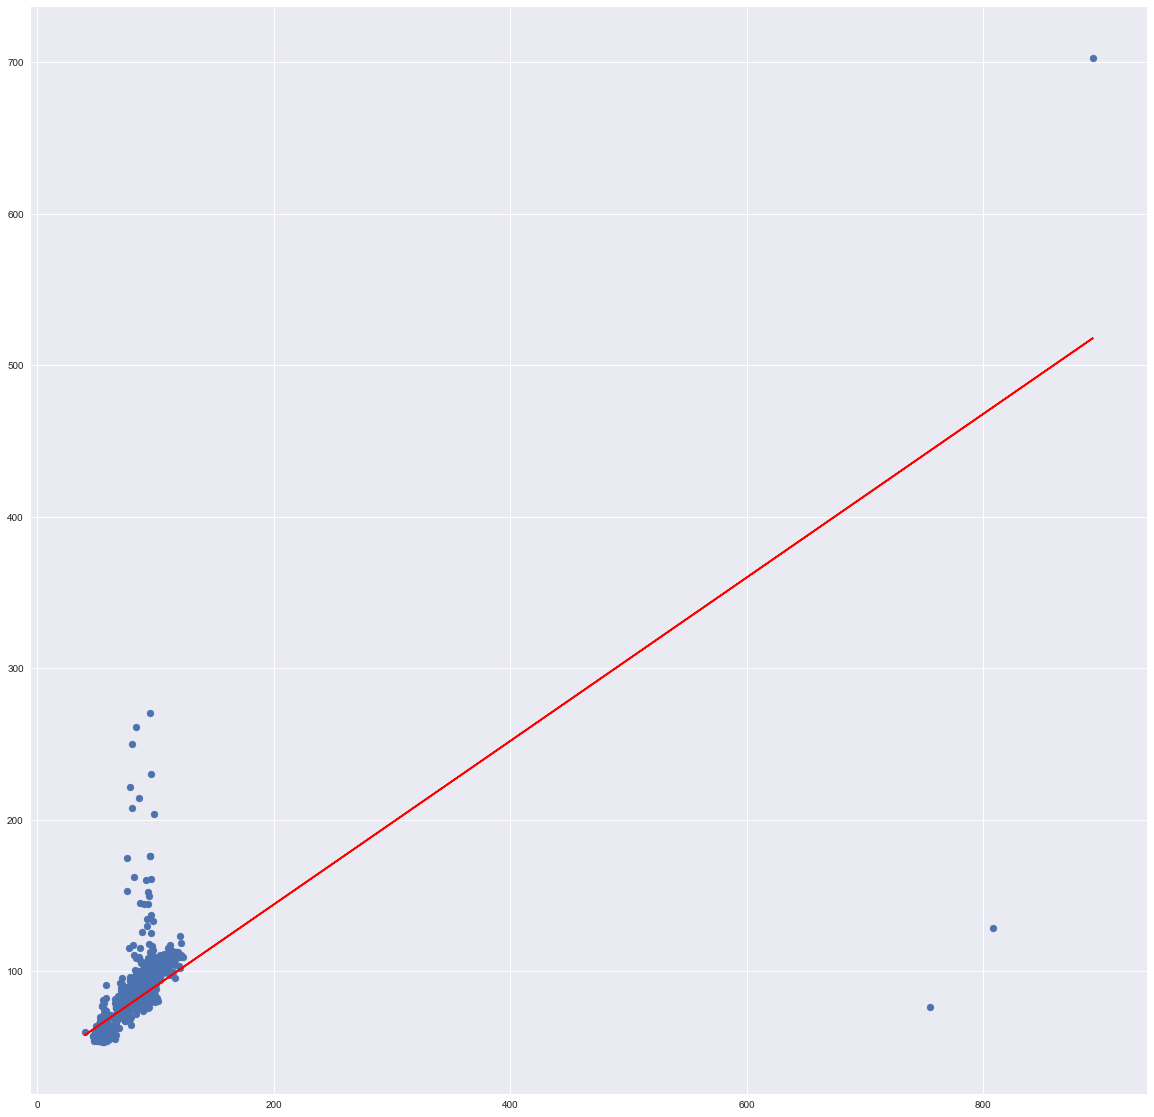

In [152]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 20, 20

# x = tips['Врем. сопротивление']
# y = tips['Предсказанное']
# fig, ax = plt.subplots()
# fit = np.polyfit(x, y, deg=1)
# ax.plot(x, fit[0] * x + fit[1], color='red')
# ax.scatter(x, y)

